# Modeling & Classification.




~~usar varios clusters, uno de 3grams, uno de nouns, uno de embeddings~~   
~~con esto buscar un clasificador multilabel (o simplemente agregarlos como features del modelo que le fedee al clasificador)~~  

Des métodos para clusterizar:    
-primero hago cluster separados para Tags, 2-3grams, Keys    
    luego agrego estas nuevas features al embedding, con eso puedo entrenar el clasificador.          
  
-segundo usando topic modeling q todavia no investigue     


Orden:  
Crear Espacio,  
normalizarlo,  
reducirlo,  
hacerle kmeans,  
obtener los clusters,  
medir siluete, gap, inertia, y precision con mi database.  
Agregar la medicion al df de mediciones.  


## Setup

In [52]:
import pandas as pd
import numpy as np
#import fasttext
from patterns import emoji_pattern
from gensim.models import Word2Vec, KeyedVectors
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import VarianceThreshold
from sentence_transformers import SentenceTransformer, util


df = pd.read_csv("db/features.csv", index_col=0, converters={'Qtoks': pd.eval,'Qstp': pd.eval,'Qkeys': pd.eval}).dropna()

df


,id,Q,Qclean,Qtoks,Qstp,Qkeys,ANS,Aclean,Atoks,Astp,Akeys,QA-keys,Q-kstr,QA-kstr,Q-stpstr
0,bc60pk,"donut or doughnut, & where are you from?",donut or doughnut where are you from,"[donut, or, doughnut, where, are, you, from]","[or, where, are, you, from]","[donut, doughnut]","donut, southern usa",donut southern usa,"['donut', 'southern', 'usa']",[],"['donut', 'southern', 'usa']","['donut', 'doughnut', 'donut', 'southern', 'usa']",donut doughnut,donut doughnut,donut doughnut
1,289mmm,help finding a song from a video description?,help finding a song from a video description,"[help, finding, a, song, from, a, video, descr...","[a, from, a]","[help, finding, song, video, description]",/r/tipofmytongue,rtipofmytongue,['rtipofmytongue'],[],['rtipofmytongue'],"['help', 'finding', 'song', 'video', 'descript...",help finding song video description,help finding song video description,help finding song video description
2,rufpr/,"i was rapedno, we had sex",i was rapedno we had sex,"[i, wa, rapedno, we, had, sex]","[i, we, had]","[wa, rapedno, sex]","if its not a yes, its no.",if its not a yes its no,"['if', 'it', 'not', 'a', 'yes', 'it', 'no']","['if', 'it', 'not', 'a', 'it', 'no']",['yes'],"['wa', 'rapedno', 'sex', 'yes']",wa rapedno sex,wa rapedno sex,wa rapedno sex
3,24vtw3,jesus h. christ what's his middle name?,jesus h christ whats his middle name,"[jesus, h, christ, whats, his, middle, name]",[his],"[jesus, h, christ, whats, middle, name]",umm... Holy. As in Holy Christ. Isn't this com...,umm Holy As in Holy Christ Isnt this common kn...,"['umm', 'Holy', 'As', 'in', 'Holy', 'Christ', ...","['in', 'this']","['umm', 'Holy', 'As', 'Holy', 'Christ', 'Isnt'...","['jesus', 'h', 'christ', 'whats', 'middle', 'n...",jesus h christ whats middle name,jesus h christ whats middle name,jesus h christ whats middle name
4,jg8san,runaways why did you run?,runaways why did you run,"[runaway, why, did, you, run]","[why, did, you]","[runaway, run]","That's how a race works. I mean, I lost, but s...",Thats how a race works I mean I lost but still,"['Thats', 'how', 'a', 'race', 'work', 'I', 'me...","['how', 'a', 'but']","['Thats', 'race', 'work', 'I', 'mean', 'I', 'l...","['runaway', 'run', 'Thats', 'race', 'work', 'I...",runaway run,runaway run,runaway run
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30600,tx1ae/,zombie puns needed,zombie puns needed,"[zombie, pun, needed]",[],"[zombie, pun, needed]",Why did the Zombie cross the road? BRAINS! W...,Why did the Zombie cross the road BRAINS Wha...,"['Why', 'did', 'the', 'Zombie', 'cross', 'the'...","['did', 'the', 'the', 'do', 'we', 'do', 'we', ...","['Why', 'Zombie', 'cross', 'road', 'BRAINS', '...","['zombie', 'pun', 'needed', 'Why', 'Zombie', '...",zombie pun needed,zombie pun needed,zombie pun needed
30601,ds6tpc,"zoo employees, what was the uh oh moment?",zoo employees what was the uh oh moment,"[zoo, employee, what, wa, the, uh, oh, moment]","[what, the]","[zoo, employee, wa, uh, oh, moment]",uh oh s t i n k y,uh oh s t i n k y,"['uh', 'oh', 's', 't', 'i', 'n', 'k', 'y']","['s', 't', 'i', 'y']","['uh', 'oh', 'n', 'k']","['zoo', 'employee', 'wa', 'uh', 'oh', 'moment'...",zoo employee wa uh oh moment,zoo employee wa uh oh moment,zoo employee wa uh oh moment
30602,i53cd6,zoomers how it is to meet the boomer?,zoomers how it is to meet the boomer,"[zoomers, how, it, is, to, meet, the, boomer]","[how, it, is, to, the]","[zoomers, meet, boomer]",there a lot like millenials i'll be honest,there a lot like millenials ill be honest,"['there', 'a', 'lot', 'like', 'millenials', 'i...","['there', 'a', 'be']","['lot', 'like', 'millenials', 'ill', 'honest']","['zoomers', 'meet', 'boomer', 'lot', 'like', '...",zoomers meet boomer,zoomers meet boomer,zoomers meet boomer
30603,dzepth,"zoomers of reddit, where are we zooming to?",zoomers of reddit where are we zooming to,"[zoomers, of, reddit, where, are, we, zooming,...","[of, where, are, we, to]","[zoomers, reddit, zooming]",the one pixel on a squ

## Modeling

In [23]:
Models = {}
gpu = False
topmods = False

### Tfidf Models

In [3]:
def tdidf_model(df, column, range=(2,3), min_df=20, threshold=1e-3, ngram=False):
    
    docs = df[column].fillna("")

    if ngram:
        tdidf = TfidfVectorizer(min_df=min_df, ngram_range=range)
    else:
        tdidf = TfidfVectorizer(min_df=min_df)

    #Create, Normalize and Reduce 
    model = tdidf.fit_transform(docs)
    model = normalize(model, axis=1, norm="max")
    model = VarianceThreshold(threshold=threshold).fit_transform(model)

    return model.toarray()

In [4]:
tdidf = {}

tdidf["Qkeys"] = tdidf_model(df, column="Q-kstr", min_df=15)

tdidf["Qclean"] = tdidf_model(df, column="Qclean", min_df=15)

#Qclean is without punct
tdidf["Q-ngrams"] = tdidf_model(df, column="Qclean", range=(2,3), min_df=15, ngram = True)

#Question+Answer nonstop lemmas
tdidf["QA-keys"] = tdidf_model(df, column="QA-kstr", min_df=15)

#i think it can help tu
tdidf["Qstp"] = tdidf_model(df, column="Q-stpstr", min_df=1)

Models["tdidf"] = tdidf

### Word2Vec Embeddings

https://kavita-ganesan.com/fasttext-vs-word2vec/

In [24]:

def w2v_doc_embedding(docs_toks):

    docs_model = []
    
    words_model = Word2Vec(docs_toks, size=300, workers=8, seed=0)

    for tokens in docs_toks:
        zero_vector = np.zeros(words_model.vector_size)
        vectors = []
        for token in tokens:
            if token in words_model.wv:
                try:
                    vectors.append(words_model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            docs_model.append(avg_vec)
        else:
            docs_model.append(zero_vector)
    return np.array(docs_model)


In [53]:
w2v = {}

w2v["Qclean"] = w2v_doc_embedding(list(df["Qclean"].astype("str")))
w2v["Qkeys"] = w2v_doc_embedding(list(df["Qkeys"]))
w2v["QA-keys"] = w2v_doc_embedding(list(df["QA-keys"]))

Models["w2v"] = w2v
w2v["Qclean"].size/300

30279.0

### Pretrained Embeddings

- SBERT , glove-6B-300
    * Q, QLess, QA, QAless  


In [7]:
pretrained = {}

if gpu:

    glove60 = KeyedVectors.load_word2vec_format("glove.6B.300d.txt", binary=False, no_header=True)
    def glove_doc_embedding(docs_toks, words_model):

        docs_model = []
        

        for tokens in docs_toks:
            zero_vector = np.zeros(words_model.vector_size)
            vectors = []
            for token in tokens:
                try:
                    vectors.append(words_model[token])
                except KeyError:
                    continue
            if vectors:
                vectors = np.asarray(vectors)
                avg_vec = vectors.mean(axis=0)
                docs_model.append(avg_vec)
            else:
                docs_model.append(zero_vector)
        return docs_model
        
    pretrained["glove-Q"] = glove_doc_embedding(list(df["Qtoks"]), glove60)


In [8]:
if gpu:
    model = SentenceTransformer('nreimers/MiniLM-L6-H384-uncased') #
    pretrained["SBERT-Q"] = model.encode(list(df["Q"].astype('str')), batch_size=70, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)


In [9]:
Models["pretrain"] = pretrained

### Topic Modeling
https://github.com/ddangelov/Top2Vec   
https://pythonrepo.com/repo/ddangelov-Top2Vec-python-natural-language-processing  
https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [10]:
from top2vec import Top2Vec
topic = {}

if gpu:
    topic["T2V-Q"] = Top2Vec(list(df["Q"].astype('str')), embedding_model='universal-sentence-encoder')

In [11]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
if topmods:

    dictionary = Dictionary(df["Qtoks"])
    key_corpus = [dictionary.doc2bow(doc) for doc in df["Qkeys"]]
    bow_corpus = [dictionary.doc2bow(doc) for doc in df["Qtoks"]]

    topic["LDA-Qkyes"] = LdaMulticore(list(key_corpus), 
                                    num_topics = 15,
                                    id2word = dictionary,                                    
                                    passes = 80,
                                    workers = 6)

    topic["LDA-Q"] = LdaMulticore(list(bow_corpus), 
                                    num_topics = 15,
                                    id2word = dictionary,                                    
                                    passes = 80,
                                    workers = 6)

                                    
    Models["topic"] = topic

# for idx, topic in Models["LDA-Qkeys"].print_topics(-1):
#     print("Topic: {} \nWords: {}".format(idx, topic))
#     print("\n")


## Clustering



Solo voy a probar con KMeans por cuestion de cantidad de datos y recursos, lo que me permite  

Con este dataset el metodo de elbow no se puede utiizar porque el error crece linearmente  

  
https://scikit-learn.org/stable/modules/clustering.html   
https://towardsdatascience.com/10-tips-for-choosing-the-optimal-number-of-clusters-277e93d72d92   
https://towardsdatascience.com/k-means-clustering-and-the-gap-statistics-4c5d414acd29  
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html    


vamos a guardar el (modelo, fecha, algoritmo, n_clusters) usados para cada clusterizaion, junto con sus métricas en un archivo runs.csv  
los clusters los vamos a guardar con (id, label#n) donde n es el número de run en un archivo clusters30615.csv 


In [20]:
for ks in Models:
    print(ks)
    for m in Models[ks]:
        print(f"    {m}")

tdidf
    Qkeys
    Qclean
    Q-ngrams
    QA-keys
    Qstp
w2v
    Qclean
    Qkeys
    QA-keys
pretrain


In [5]:
import faiss

n_clus0 = 8
n_clus1 = 10
n_clus2 = 20

class FaissKMeans:
    def __init__(self, n_clus=10, n_init=10, max_iter=50):
        self.n_clusters = n_clus
        self.n_init = n_init
        self.max_iter = max_iter
        self.kmeans = None
        self.cluster_centers_ = None
        self.inertia_ = None

    def fit(self, X, y):
        self.kmeans = faiss.Kmeans(d=X.shape[1],
                                   k=self.n_clusters,
                                   niter=self.max_iter,
                                   nredo=self.n_init)
        self.kmeans.train(X.astype(np.float32))
        self.cluster_centers_ = self.kmeans.centroids
        self.inertia_ = self.kmeans.obj[-1]
        #print(self.kmeans.obj)

    def predict(self, X):
        return self.kmeans.index.search(X.astype(np.float32), 1)[1]

#puede q sirva el fastclustering

#segundo método, Token Count Vectorizer - Fast_clustering
#clusters = util.community_detection(red_emb, min_community_size=50, threshold=0.40)
#print(f"número de tweets clusterizados: {sum(len(clus) for clus in clusters)}")
#df["label2"] = 99

#for i, cluster in enumerate(clusters):
#    print("\nCluster {}, #{} Elements ".format(i+1, len(cluster)))
#    for sentence_id in cluster[0:20]:
#        print("\t", df["proc_res"][sentence_id])
#for i, cluster in enumerate(clusters):
#    for sentence_id in cluster:
#        df["label2"][sentence_id] = i     

Cual algoritmo es mas optimo para cada modelo w2v?



In [152]:
def get_error(X,ran=(8,20)):
    #from kneed import KneeLocator, DataGenerator

    distortions = []
    for i in range(5,20):
        fkm = FaissKMeans(n_clus=i)
        fkm.fit(X, [])
        distortions.append(fkm.inertia_)
    return distortions

def get_error2(X,ran=(8,20)):
    #from kneed import KneeLocator, DataGenerator

    distortions = []
    for i in range(10,15):
        skm = KMeans(n_clusters=i)
        skm.fit(X)
        distortions.append(skm.inertia_)
    return distortions

def check_testdb(clus_df, m_name):

    return

# w2vQclean = get_error(Models["w2v"]["Qclean"])
# w2vQkeys = get_error(Models["w2v"]["Qkeys"])
# w2vQAkeys = get_error(Models["w2v"]["QA-keys"])

# from matplotlib import pyplot as plt

# plt.plot(w2vQAkeys)
# plt.plot(w2vQclean)
# plt.plot(w2vQkeys)
# # plt.legend()
check_testdb(Models["w2v"]["Qclean"], "w2v-Qclean")

244

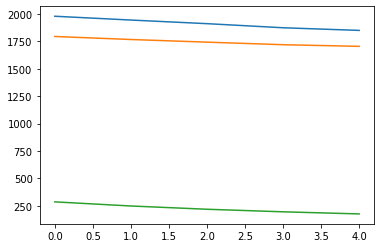

In [9]:

w2vQclean = get_error2(Models["w2v"]["Qclean"])
w2vQkeys = get_error2(Models["w2v"]["Qkeys"])
w2vQAkeys = get_error2(Models["w2v"]["QA-keys"])

from matplotlib import pyplot as plt

plt.plot(w2vQAkeys)
plt.plot(w2vQclean)
plt.plot(w2vQkeys)



Por curiosidad quiero ver primero las stopwords, y que es lo que clusteriza

In [14]:
]

[array([4]),
 array([5]),
 array([0]),
 array([3]),
 array([12]),
 array([14]),
 array([9]),
 array([16]),
 array([13]),
 array([19]),
 array([0]),
 array([12]),
 array([5]),
 array([1]),
 array([9]),
 array([18]),
 array([15]),
 array([6]),
 array([17]),
 array([17]),
 array([15]),
 array([5]),
 array([0]),
 array([14]),
 array([1]),
 array([5]),
 array([6]),
 array([15]),
 array([6]),
 array([6]),
 array([15]),
 array([6]),
 array([15]),
 array([1]),
 array([15]),
 array([13]),
 array([5]),
 array([8]),
 array([6]),
 array([0]),
 array([16]),
 array([15]),
 array([15]),
 array([15]),
 array([15]),
 array([12]),
 array([15]),
 array([0]),
 array([10]),
 array([10]),
 array([7]),
 array([11]),
 array([7]),
 array([19]),
 array([7]),
 array([7]),
 array([7]),
 array([7]),
 array([13]),
 array([7]),
 array([7]),
 array([19]),
 array([11]),
 array([11]),
 array([11]),
 array([11]),
 array([11]),
 array([7]),
 array([17]),
 array([7]),
 array([4]),
 array([4]),
 array([4]),
 array([7]),
 a

In [16]:
from sklearn.cluster import KMeans



#vemos los primeros clusters, al ser con ngrams  la forma en la que comienza la pregunta tiene mucho peso


In [17]:

#Compara la cantidad de aciertos con los df de test

#check_results()
    

In [210]:

        

def run(X, m_name, n_clus=15, iters=150, algo="fkm"):

    run_df = pd.read_csv("results/runs.csv")
    clus_df = pd.read_csv("results/clusters30615.csv", index_col=0, dtype='str')

    if algo is "fkm":
        faisskm = FaissKMeans(n_clus=n_clus)
        faisskm.fit(X, [])
        predictions = [x[0] for x in list(faisskm.predict(X))]
        clus_df[m_name] = predictions

    n_run = 1
    test_df = pd.read_csv("db/test_db.csv", index_col=0)
    true_df = test_df[test_df["2"]]
    false_df = test_df[test_df["2"] == False]


    n = len(true_df)
    m = len(false_df)
    
    
    same_c = 0
    for index, row in true_df.iterrows():

        print(index, clus_df[m_name][clus_df.id == row[0]], clus_df[m_name][clus_df.id == row[1]])#, clus_df[m_name][clus_df.id == row[1]])

        if clus_df[m_name][clus_df.id == row[0]].values[0] == clus_df[m_name][clus_df.id == row[1]].values[0]:
            same_c += 1
    
    # diff_c = 0
    # for i in range(m):
    #     if int(clus_df[clus_df.id != false_df.iloc[i][0]][m_nanem]) !=  int(clus_df[clus_df.id == false_df.iloc[i][0]][m_name]):
    #         diff_c += 1
        
    #run_df.append([n_run, m_name, algo, n_clus, faisskm.inertia_, check_testdb(clus_df, m_name)])

    #int(clus_df[clus_df.id == "bc60pk"]["w2v-Qclean"])

    return same_c



    #run_df.to_csv("results/runs.csv")
    #clus_df.to_csv("results/clusters30615.csv")

    #va guardar en runs_df los datos, y va a registrar las labels en clus_df
    #tengo ampliar los archivos, no sobreescrvirlos

run(Models["w2v"]["Qclean"], "w2v-Qclean")

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-210-b6c2f853aea3>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if algo is "fkm":


0 17556    6
Name: w2v-Qclean, dtype: int64 7705    6
Name: w2v-Qclean, dtype: int64
1 17556    6
Name: w2v-Qclean, dtype: int64 7739    6
Name: w2v-Qclean, dtype: int64
2 17556    6
Name: w2v-Qclean, dtype: int64 25792    6
Name: w2v-Qclean, dtype: int64
3 17556    6
Name: w2v-Qclean, dtype: int64 29293    6
Name: w2v-Qclean, dtype: int64
4 17556    6
Name: w2v-Qclean, dtype: int64 17554    2
Name: w2v-Qclean, dtype: int64
5 17556    6
Name: w2v-Qclean, dtype: int64 17542    6
Name: w2v-Qclean, dtype: int64
6 17556    6
Name: w2v-Qclean, dtype: int64 14637    6
Name: w2v-Qclean, dtype: int64
7 17556    6
Name: w2v-Qclean, dtype: int64 25790    1
Name: w2v-Qclean, dtype: int64
8 17556    6
Name: w2v-Qclean, dtype: int64 8196    6
Name: w2v-Qclean, dtype: int64
9 17556    6
Name: w2v-Qclean, dtype: int64 14957    6
Name: w2v-Qclean, dtype: int64
10 17556    6
Name: w2v-Qclean, dtype: int64 18428    3
Name: w2v-Qclean, dtype: int64
11 17556    6
Name: w2v-Qclean, dtype: int64 17544    3


IndexError: index 0 is out of bounds for axis 0 with size 0

In [187]:
def print_kmc_clus(n=10):
    import random
    q_clus = [[] for i in range(n_clusters)]

    for sentence_id, cluster_id in enumerate(kmc.labels_):
        q_clus[cluster_id].append(df.iloc[sentence_id].Q)

    for i, cluster in enumerate(q_clus):
        print(f"Cluster {i+1}, len: {len(cluster)}" )
        for tw in random.sample(cluster, n):
            print(tw)
        print("\n")


def check_testdb(clus_df, m_name):
    test_df = pd.read_csv("db/test_db.csv", index_col=0)
    true_df = test_df[test_df["2"]]
    false_df = test_df[test_df["2"] == False]

    n = len(true_df)
    m = len(false_df)
    same_c = 0
    for i in range(n):
        if int(clus_df.id[true_df.iloc[i][0]][m_name]) ==  int(clus_df.id[true_df.iloc[i][1]][m_name]):
            same_c += 1
    
    diff_c = 0
    for i in range(m):
        if int(clus_df.id[false_df.iloc[i][0]][m_name]) !=  int(clus_df.id[false_df.iloc[i][1]][m_name]):
            diff_c += 1
        
    return same_c/n, diff_c/m
        
    

## Classifying 
